In [ ]:
#testing vision-to-text models

In [1]:
!pip install --upgrade google-cloud-vision
!pip install google-cloud-translate==2.0.1
!pip install "google-cloud-aiplatform>=1.38"

  Using cached google_cloud_core-1.7.3-py2.py3-none-any.whl (28 kB)
  Using cached google_auth-1.35.0-py2.py3-none-any.whl (152 kB)
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.27.0
    Uninstalling google-auth-2.27.0:
      Successfully uninstalled google-auth-2.27.0
  Attempting uninstall: google-cloud-core
    Found existing installation: google-cloud-core 2.4.1
    Uninstalling google-cloud-core-2.4.1:
      Successfully uninstalled google-cloud-core-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 2.14.0 requires google-auth<3.0dev,>=2.23.3, but you have google-auth 1.35.0 which is incompatible.
google-cloud-storage 2.14.0 requires google-cloud-core<3.0dev,>=2.3.0, but you have google-cloud-core 1.7.3 which is incompatible.
google-auth-oauthlib 1.1.0 requires google-auth>=2.15.0, but you have 

In [41]:
import cv2

In [13]:
def localize_objects(path):
    """Localize objects in the local image.

    Args:
    path: The path to the local file.
    """
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    objects = client.object_localization(image=image).localized_object_annotations

    print(f"Number of objects found: {len(objects)}")
    
    objects_list = []
    bounds_list = []
    for object_ in objects:
        objects_list.append(object_.name)
        print(f"\n{object_.name} (confidence: {object_.score})")
        print("Normalized bounding polygon vertices: ")
        bounds_per_object = []
        for vertex in object_.bounding_poly.normalized_vertices:
            bounds_per_object.append((vertex.x, vertex.y))
            print(f" - ({vertex.x}, {vertex.y})")
        bounds_list.append(bounds_per_object)
            
    return objects_list, bounds_list

In [14]:
coffee_shop = "/Users/justin/Desktop/coffee_3839f67b-f767-4937-baac-bf300773bdac_900x.jpg"

objects_list, bounds_list = localize_objects(coffee_shop)

Number of objects found: 4

Lighting (confidence: 0.6941819787025452)
Normalized bounding polygon vertices: 
 - (0.03343801200389862, 0.001070535508915782)
 - (0.8404603004455566, 0.001070535508915782)
 - (0.8404603004455566, 0.33016344904899597)
 - (0.03343801200389862, 0.33016344904899597)

Table (confidence: 0.6430790424346924)
Normalized bounding polygon vertices: 
 - (0.8472530245780945, 0.7505187392234802)
 - (0.9951115250587463, 0.7505187392234802)
 - (0.9951115250587463, 0.9964694380760193)
 - (0.8472530245780945, 0.9964694380760193)

Furniture (confidence: 0.624107301235199)
Normalized bounding polygon vertices: 
 - (0.7437737584114075, 0.45053815841674805)
 - (0.904347836971283, 0.45053815841674805)
 - (0.904347836971283, 0.8809151649475098)
 - (0.7437737584114075, 0.8809151649475098)

Table (confidence: 0.5161842107772827)
Normalized bounding polygon vertices: 
 - (0.1584455519914627, 0.8428836464881897)
 - (0.29590511322021484, 0.8428836464881897)
 - (0.29590511322021484, 0

In [15]:
objects_list

['Lighting', 'Table', 'Furniture', 'Table']

In [16]:
bounds_list

[[(0.03343801200389862, 0.001070535508915782),
  (0.8404603004455566, 0.001070535508915782),
  (0.8404603004455566, 0.33016344904899597),
  (0.03343801200389862, 0.33016344904899597)],
 [(0.8472530245780945, 0.7505187392234802),
  (0.9951115250587463, 0.7505187392234802),
  (0.9951115250587463, 0.9964694380760193),
  (0.8472530245780945, 0.9964694380760193)],
 [(0.7437737584114075, 0.45053815841674805),
  (0.904347836971283, 0.45053815841674805),
  (0.904347836971283, 0.8809151649475098),
  (0.7437737584114075, 0.8809151649475098)],
 [(0.1584455519914627, 0.8428836464881897),
  (0.29590511322021484, 0.8428836464881897),
  (0.29590511322021484, 0.9909536838531494),
  (0.1584455519914627, 0.9909536838531494)]]

In [43]:
def annotate_image(objects_list, bounds_list, path):

    import cv2
    import numpy as np


    # Load the image
    image_path = path  # Replace with the path to your image
    image = cv2.imread(image_path)



    # Define multiple bounds and corresponding labels
    all_bounds = bounds_list

    #define multiple object labels
    labels = objects_list

    # Convert bounds from float to image coordinates
    height, width, _ = image.shape
    scaled_all_bounds = [
        [(int(b[0] * width), int(b[1] * height)) for b in bounds] for bounds in all_bounds
    ]

    # Draw rectangles, filled rectangles, and labels on the image
    color = (0, 255, 0)  # RGB color, here it's green
    thickness = 2  # Thickness of the rectangle
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    rect_color = (0, 0, 0)  # RGB color, here it's red
    image_with_bounds = image.copy()

    for bounds, label in zip(scaled_all_bounds, labels):
        # Draw the rectangle
        cv2.polylines(image_with_bounds, [np.array(bounds)], isClosed=True, color=color, thickness=thickness)

        # Calculate the position for the text label
        label_position = (bounds[0][0], bounds[0][1] - 10)  # Adjust the offset as needed

        # Check if the label is outside the image dimensions and adjust its position
        label_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        # Ensure label stays within the image dimensions
        label_position = (
            max(0, min(label_position[0], width - label_size[0] - 1)),
            max(label_size[1], min(label_position[1], height - 1))
        )

        # Draw the filled rectangle behind the text label
        rect_position = (label_position[0] - 5, label_position[1] - label_size[1] - 5)
        rect_size = (label_size[0] + 10, label_size[1] + 10)

        # Ensure the filled rectangle stays within the image dimensions
        rect_position = (
            max(0, min(rect_position[0], width - 1)),
            max(0, min(rect_position[1], height - 1))
        )

        rect_size = (
            min(rect_size[0], width - rect_position[0]),
            min(rect_size[1], height - rect_position[1])
        )

        cv2.rectangle(image_with_bounds, rect_position, (rect_position[0] + rect_size[0], rect_position[1] + rect_size[1]), rect_color, -1)

        # Add the text label to the image
        cv2.putText(image_with_bounds, label, label_position, font, font_scale, color, font_thickness, cv2.LINE_AA)

    # Save or display the image with bounds
    cv2.imwrite("/Users/justin/Desktop/output_image_with_bounds.jpg", image_with_bounds)

    # Convert OpenCV image to bytes
    _, image_bytes = cv2.imencode('.jpg', image_with_bounds)
    image_bytes = image_bytes.tobytes()
    

    return image_with_bounds, image_bytes


In [32]:
def detect_text_uri(uri):
    """Detects text in the file located in Google Cloud Storage or on the Web."""
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print("Texts:")

    for text in texts:
        print(f'\n"{text.description}"')

        vertices = [
            f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices
        ]

        print("bounds: {}".format(",".join(vertices)))

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )


In [33]:
detect_text_uri("gs://purplecow/coffee_3839f67b-f767-4937-baac-bf300773bdac_900x.jpg")

Texts:

"0000
Sipsip
VIOLE
40
9211
MENU
COFFEE fat
- Teat
in ma
Any
HOT CHOCOLATE
H
Salad
V-/DS","
bounds: (110,160),(678,160),(678,590),(110,590)

"0000"
bounds: (200,394),(266,553),(177,590),(111,431)

"Sipsip"
bounds: (247,220),(311,220),(311,247),(247,247)

"VIOLE"
bounds: (255,320),(230,321),(230,314),(255,313)

"40"
bounds: (498,539),(498,512),(507,512),(507,539)

"9211"
bounds: (523,510),(524,529),(516,529),(515,510)

"MENU"
bounds: (608,168),(667,160),(668,171),(609,179)

"COFFEE"
bounds: (598,183),(623,179),(624,185),(599,189)

"fat"
bounds: (630,178),(640,176),(641,182),(631,184)

"-"
bounds: (638,181),(648,178),(650,187),(641,190)

"Teat"
bounds: (652,177),(675,170),(678,179),(655,186)

"in"
bounds: (642,213),(634,214),(633,208),(641,207)

"ma"
bounds: (625,215),(603,218),(602,212),(624,209)

"Any"
bounds: (639,258),(623,258),(623,252),(639,252)

"HOT"
bounds: (595,275),(605,275),(605,282),(595,282)

"CHOCOLATE"
bounds: (607,275),(634,276),(634,284),(607,283)

"H"
bounds: (6

In [34]:
def localize_objects(path, save_path, src_language, tgt_language):
    """Localize objects in the local image.

    Args:
    path: The path to the local file.
    """

    client = vision.ImageAnnotatorClient()

    """
    #open image from file path
    with open(path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    """
    
    #image from URI

    image = vision.Image()
    image.source.image_uri = path

    objects = client.object_localization(image=image).localized_object_annotations

    #print(f"Number of objects found: {len(objects)}")
    
    objects_list = [] #get the identified objects
    bounds_list = [] #get the coordinates of the bounding box
    for object_ in objects:
        objects_list.append(object_.name)
        #print(f"\n{object_.name} (confidence: {object_.score})")
        #print("Normalized bounding polygon vertices: ")
        bounds_per_object = []
        for vertex in object_.bounding_poly.normalized_vertices:
            bounds_per_object.append((vertex.x, vertex.y))
            #print(f" - ({vertex.x}, {vertex.y})")
        bounds_list.append(bounds_per_object)
        
    #translate objects list to user input source language (since Vision automaticaly uses english)
    src_translated_object_list = []
    tgt_translated_object_list = []
    for i in range(len(objects_list)):

        src_translated_text = translate_text(src_language, objects_list[i])
        src_translated_object_list.append(src_translated_text)
        
        tgt_translated_text = translate_text(tgt_language, objects_list[i])
        tgt_translated_object_list.append(tgt_translated_text)
        
        
        
    #pass the target translated object list to the annotate_image function
    
    #output objects list in source language
    #objects_list = src_translated_object_list
        
    image_annotated = annotate_image(tgt_translated_object_list, bounds_list, path, save_path)
    

            
    return image_annotated, src_translated_object_list, tgt_translated_object_list

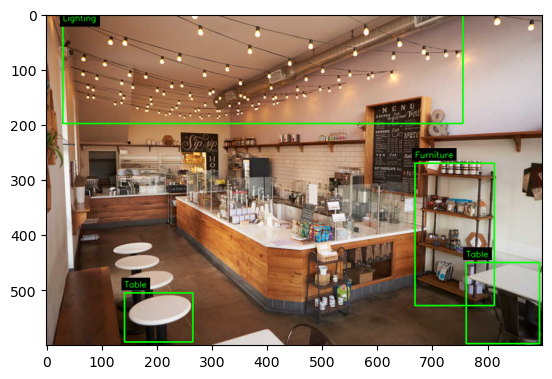

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

image_annotated, image_bytes = annotate_image(objects_list, bounds_list, coffee_shop)
plt.imshow(image_annotated[:,:,::-1])
plt.show()

#Import image
#image_annotated = cv2.imread("/Users/justin/Desktop/output_image_with_bounds.jpg")

In [31]:
from google.cloud import storage

import os

# Set the path to your service account key file
os.environ["GCLOUD_PROJECT"] = "purplecow"

def upload_blob(bucket_name, source_file_bytes, destination_blob_name):
    """Uploads a file to the bucket"""

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    #blob.upload_from_filename(source_file_name)
    # Upload the image data to the blob
    blob.upload_from_string(source_file_bytes, content_type='image/jpeg')

    


BUCKET_NAME = "purplecow"
SOURCE_FILE_NAME = image_bytes
DESTINATION_FILE_NAME = "annotated_image.jpg"

upload_blob(BUCKET_NAME, SOURCE_FILE_NAME, DESTINATION_FILE_NAME)

In [8]:
def detect_language(text: str) -> dict:
    """Detects the text's language."""
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.detect_language(text)

    #print(f"Text: {text}")
    #print("Confidence: {}".format(result["confidence"]))
    #print("Language: {}".format(result["language"]))
    #print('\n')

    return text, result["language"]

In [9]:
object_lang_list = []

for i in range(len(objects_list)):
    
  object, language = detect_language(objects_list[i])
  object_lang_list.append((object, language))

In [10]:
object_lang_list

[('Lighting', 'en'), ('Table', 'en'), ('Furniture', 'en'), ('Table', 'en')]

In [37]:
def translate_text(target: str, text: str) -> dict:
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    #print("Text: {}".format(result["input"]))
    #print("Translation: {}".format(result["translatedText"]))
    #print("Detected source language: {}".format(result["detectedSourceLanguage"]))

    return result["translatedText"]


In [13]:
object_translated_list = []

for i in range(len(objects_list)):
    
  translated_text = translate_text('fr', objects_list[i])
  object_translated_list.append(translated_text)

In [14]:
object_translated_list

['Éclairage', 'Tableau', 'Meubles', 'Tableau']

In [35]:
object_translated_list

['Éclairage', 'Tableau', 'Meubles', 'Tableau']

In [97]:
# TODO(developer): Vertex AI SDK - uncomment below & run
# pip3 install --upgrade --user google-cloud-aiplatform
# gcloud auth application-default login

import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part


def generate_text(project_id: str, location: str, img_uri, object_translated_list, language, level) -> str:
    # Initialize Vertex AI
    vertexai.init(project=project_id, location=location)
    # Load the model
    multimodal_model = GenerativeModel("gemini-pro-vision")
    # Query the model
    response = multimodal_model.generate_content(
        [
            # Add an example image
            Part.from_uri(
                img_uri, mime_type="image/jpeg"
            ),
            # Add an example query
            f"I am trying to imrpove my {language} speaking ability. The provided photo displays what I am currently seeing in my environment, please create 3 {level} questions in the {language} language using these words '{object_translated_list}'  that I could use to practice learning {language} given my surroundings. Ensure there is a question focuses on a different one of the 5 W's (who, what, when, where, why) or how. Do not preface the examples, just provide them. Separate each example with a newline character. Provide numbered examples."
            ,
        ]
    )
    #print(response)
    return response.text


In [107]:
img_uri = "gs://purplecow/output_image_with_bounds.jpg"
language = 'French'
level = 'beginner'

example_sentences = generate_text('purplecow', 'northamerica-northeast1', img_uri, object_translated_list, language, level)

print(f'Here is are example sentences of using the word(s) {object_translated_list}: ', example_sentences)

Here is are example sentences of using the word(s) ['Éclairage', 'Tableau', 'Meubles', 'Tableau']:   1. Où se trouve le tableau ?
2. Pourquoi y a-t-il autant de meubles ?
3. Quand est-ce que l'éclairage a été installé ?


In [108]:
example_sentences

" 1. Où se trouve le tableau ?\n2. Pourquoi y a-t-il autant de meubles ?\n3. Quand est-ce que l'éclairage a été installé ?"

In [109]:
#convert example sentences to list
example_sentences_list = example_sentences.splitlines()
print(example_sentences_list)

[' 1. Où se trouve le tableau ?', '2. Pourquoi y a-t-il autant de meubles ?', "3. Quand est-ce que l'éclairage a été installé ?"]


In [111]:
sentence_translated_list = []

for i in range(len(example_sentences_list)):
    
    translated_text = translate_text('en', example_sentences_list[i])
    sentence_translated_list.append(translated_text)
    
print(sentence_translated_list)

[' 1. Where is the table located?', '2. Why is there so much furniture?', '3. When was the lighting installed?']


In [77]:
#zip together french and english examples
zip(example_sentences, sentence_translated_list)

In [5]:
from iso639 import Lang

lg = Lang("French")

print(lg.pt1)

fr


In [10]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part

vertexai.init(project='purplecow', location= 'northamerica-northeast1')

multimodal_model = GenerativeModel("gemini-pro-vision")

generative_models.Part

NameError: name 'generative_models' is not defined

In [ ]:
# Imports the Google Cloud client library
from google.cloud import vision

def run_quickstart(input_img) -> vision.EntityAnnotation:
    """Provides a quick start example for Cloud Vision."""

    # Instantiates a client
    client = vision.ImageAnnotatorClient()

    # The URI of the image file to annotate
    file_uri = input_img

    image = vision.Image()
    image.source.image_uri = file_uri

    # Performs label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations

    print("Labels:")
    for label in labels:
        print(label.description)

    return labels


In [ ]:
test_img = "gs://cloud-samples-data/vision/label/wakeupcat.jpg"

run_quickstart(test_img)

Labels:
Cat
Window
Felidae
Carnivore
Jaw
Small to medium-sized cats
Gesture
Whiskers
Window blind
Fawn


[mid: "/m/01yrx"
description: "Cat"
score: 0.95645946
topicality: 0.95645946
, mid: "/m/0d4v4"
description: "Window"
score: 0.9388401
topicality: 0.9388401
, mid: "/m/0307l"
description: "Felidae"
score: 0.8956605
topicality: 0.8956605
, mid: "/m/01lrl"
description: "Carnivore"
score: 0.88513833
topicality: 0.88513833
, mid: "/m/01k9lj"
description: "Jaw"
score: 0.8803268
topicality: 0.8803268
, mid: "/m/07k6w8"
description: "Small to medium-sized cats"
score: 0.8631074
topicality: 0.8631074
, mid: "/m/0244x1"
description: "Gesture"
score: 0.85260487
topicality: 0.85260487
, mid: "/m/01l7qd"
description: "Whiskers"
score: 0.84995687
topicality: 0.84995687
, mid: "/m/031b6r"
description: "Window blind"
score: 0.8345817
topicality: 0.8345817
, mid: "/m/0276krm"
description: "Fawn"
score: 0.81613505
topicality: 0.81613505
]

In [ ]:
def detect_labels(path):
    """Detects labels in the file."""
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.label_detection(image=image)
    labels = response.label_annotations
    print("Labels:")

    for label in labels:
        print(label.description)

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )
    return labels

In [ ]:
coffee_shop = "/Users/justin/Desktop/coffee_3839f67b-f767-4937-baac-bf300773bdac_900x.jpg"

labels = detect_labels(coffee_shop)

Labels:
Property
Furniture
Shelf
Shelving
Wood
Interior design
Floor
Table
Building
Wall
